In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))  # project_root를 import 경로에 추가

import torch, numpy as np, matplotlib.pyplot as plt
from exp.data_utils import make_or_load_data
from exp.model_utils import LinearReg, save_init_state, load_init_state
from exp.fairness import make_or_load_perms
from exp.train_loops import run_bgd, run_sgd, run_mbgd


In [2]:
# 데이터 & 공정성 산출물 준비
Xtr, Ytr, Xval, Yval = make_or_load_data("C:/Users/USER/COMsTest_experiment/project_root/artifacts/data.npz", N=10000, sigma=0.5, seed=2025)

# 초기 가중치 스냅샷(처음 1회만 저장됨)
init_path = "C:/Users/USER/COMsTest_experiment/project_root/artifacts/init_state.pth"
if not os.path.exists(init_path):
    save_init_state(LinearReg(), init_path)

EPOCHS = 80
perms = make_or_load_perms(n_train=Xtr.shape[0], epochs=EPOCHS, seed=999, path="C:/Users/USER/COMsTest_experiment/project_root/artifacts/perms.pt")

def fresh_model():
    m = LinearReg()
    load_init_state(m, init_path)  # 동일 초기화
    return m


In [3]:
# === Artifacts 상태 점검 ===
import os, sys, numpy as np, torch, json
from pathlib import Path

# 1) 경로 자동 판별: notebooks/driver.ipynb에서 실행해도, project_root에서 실행해도 동작
CWD = Path.cwd()
cand_paths = [
    CWD / "artifacts",           # project_root에서 실행하는 경우
    CWD / "../artifacts",        # notebooks/driver.ipynb에서 실행하는 경우
]
ART = None
for p in cand_paths:
    if (p / "data.npz").exists() and (p / "init_state.pth").exists() and (p / "perms.pt").exists():
        ART = p
        break
if ART is None:
    raise FileNotFoundError("artifacts 폴더를 찾지 못했습니다. driver.ipynb의 작업 디렉토리와 경로를 확인하세요.")

print(f"[OK] artifacts dir: {ART.resolve()}")

# 2) data.npz 확인
Z = np.load(ART / "data.npz")
print(" - data.npz keys:", Z.files)
X, y = Z["X"], Z["y"]
train_idx, val_idx = Z["train_idx"], Z["val_idx"]
N = len(X)
print(f" - X shape: {X.shape}, y shape: {y.shape}, N={N}")
print(f" - train/val sizes: {len(train_idx)}/{len(val_idx)} (sum={len(train_idx)+len(val_idx)})")

# 무결성 체크: 인덱스 분할이 전체를 정확히 커버하고 서로 겹치지 않는지
ok_cover = (set(train_idx) | set(val_idx)) == set(range(N))
ok_disjoint = len(set(train_idx) & set(val_idx)) == 0
print(f" - split cover all? {ok_cover}, disjoint? {ok_disjoint}")

# 3) init_state.pth 확인
state = torch.load(ART / "init_state.pth", map_location="cpu")
print(" - init_state.pth keys:", list(state.keys()))
w = state.get("lin.weight", None)
b = state.get("lin.bias", None)
if w is not None and b is not None:
    print(f"   weight shape: {tuple(w.shape)}, bias shape: {tuple(b.shape)}")
else:
    print("   [WARN] 예상 키(lin.weight/lin.bias)를 찾지 못했습니다. 모델 클래스명을 확인하세요.")

# 4) perms.pt 확인 (epoch별 셔플 인덱스)
perms = torch.load(ART / "perms.pt", map_location="cpu")
print(f" - perms type: {type(perms)}, epochs: {len(perms)}")

# 첫 에폭에 대한 기본 검증
n_train = len(train_idx)
ex = perms[0]
ok_len = (len(ex) == n_train)
ok_range = (ex.min().item() >= 0 and ex.max().item() < n_train)
ok_unique = (len(torch.unique(ex)) == n_train)
print(f"   epoch0 perm: len==n_train? {ok_len}, rangeOK? {ok_range}, all-unique? {ok_unique}")
print(f"   epoch0 perm head: {ex[:10].tolist()}")

# 5) 간단 통계 출력 (선택)
print(f" - X mean/std: {float(X.mean()):.3f} / {float(X.std()):.3f}")
print(f" - y mean/std: {float(y.mean()):.3f} / {float(y.std()):.3f}")

print("\n[SUMMARY]")
print(" data.npz: X, y, train_idx, val_idx  → 데이터 및 분할(고정)")
print(" init_state.pth: 모델 초기 가중치 스냅샷(고정)")
print(" perms.pt: epoch별 셔플 인덱스(고정)")


[OK] artifacts dir: C:\Users\USER\COMsTest_experiment\project_root\notebooks\artifacts
 - data.npz keys: ['X', 'y', 'train_idx', 'val_idx']
 - X shape: (10000, 2), y shape: (10000, 1), N=10000
 - train/val sizes: 8000/2000 (sum=10000)
 - split cover all? True, disjoint? True
 - init_state.pth keys: ['lin.weight', 'lin.bias']
   weight shape: (1, 2), bias shape: (1,)
 - perms type: <class 'list'>, epochs: 80
   epoch0 perm: len==n_train? True, rangeOK? True, all-unique? True
   epoch0 perm head: [1152, 4428, 1547, 4467, 3768, 3594, 1017, 2247, 7961, 5406]
 - X mean/std: 0.007 / 1.003
 - y mean/std: 0.696 / 2.884

[SUMMARY]
 data.npz: X, y, train_idx, val_idx  → 데이터 및 분할(고정)
 init_state.pth: 모델 초기 가중치 스냅샷(고정)
 perms.pt: epoch별 셔플 인덱스(고정)


In [4]:
LR = 1e-2
res_bgd  = run_bgd(fresh_model(), Xtr, Ytr, Xval, Yval, epochs=EPOCHS, lr=LR)
res_sgd  = run_sgd(fresh_model(), Xtr, Ytr, Xval, Yval, perms, epochs=EPOCHS, lr=LR)
res_mbgd = run_mbgd(fresh_model(), Xtr, Ytr, Xval, Yval, perms, epochs=EPOCHS, lr=LR, batch=64)


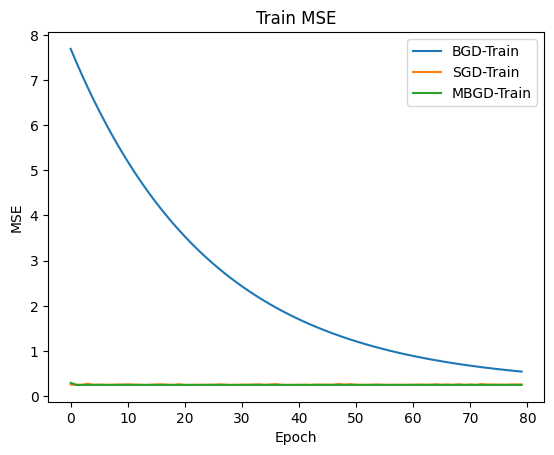

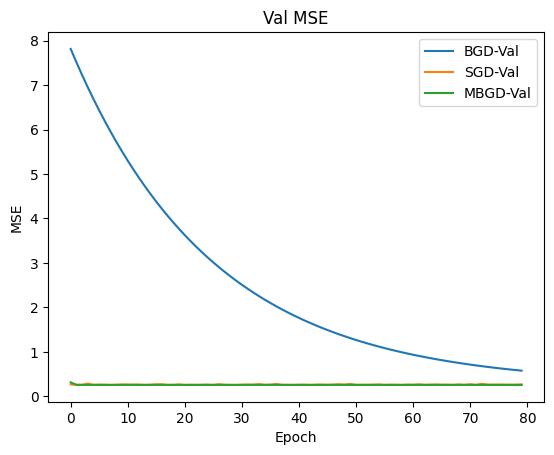

Saved: results/summary.csv


In [5]:
plt.figure(); 
plt.plot(res_bgd["train"], label="BGD-Train")
plt.plot(res_sgd["train"], label="SGD-Train")
plt.plot(res_mbgd["train"], label="MBGD-Train")
plt.title("Train MSE"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.show()

plt.figure();
plt.plot(res_bgd["val"], label="BGD-Val")
plt.plot(res_sgd["val"], label="SGD-Val")
plt.plot(res_mbgd["val"], label="MBGD-Val")
plt.title("Val MSE"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.show()

# 결과 요약 CSV
os.makedirs("../results", exist_ok=True)
import csv
with open("../results/summary.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["method", "final_val_mse", "total_time_sec"])
    w.writerow(["BGD",  res_bgd["val"][-1],  res_bgd["time"]])
    w.writerow(["SGD",  res_sgd["val"][-1],  res_sgd["time"]])
    w.writerow(["MBGD", res_mbgd["val"][-1], res_mbgd["time"]])
print("Saved: results/summary.csv")


In [6]:
import importlib, exp.train_loops as TL
importlib.reload(TL)

<module 'exp.train_loops' from 'C:\\Users\\USER\\COMsTest_experiment\\project_root\\exp\\train_loops.py'>